# Exploring optimisation techniques for modelling magnetic ordering using neutron diffraction

# 1. Introduction

The ions in antiferromagnetic substances are ordered such that their magnetic moments are antiparallel, resulting in the substances having no gross external magnetisation.  The characteristic temperature at which antiferromagnetism becomes apparent is called the Néel temperature or *transition temperature T0*. Below *T0* the ions are antiferromagnetically aligned and the unit cell is doubled as two neighbouring ions must be included. [[1]](https://journals.aps.org/pr/pdf/10.1103/PhysRev.76.1256.2)

Neutrons have magnetic moments and so can interact with the ions. Therefore, neutron diffraction experiments can directly detect antiferromagnetism and determine the microscopic magnetic structure of a substance. [[2](https://www.isis.stfc.ac.uk/Pages/Neutron-diffraction.aspx)]

In this project, the manganese(II) compound methylammonium manganese(II) formate (CH<sub>3</sub>NH<sub>3</sub>Mn(HCO<sub>2</sub>)<sub>3</sub>) [[3](http://dx.doi.org/10.1039/C6TC03992H)] was the antiferromagnetic material under investigation. Neutron diffraction data collected at ISIS was analysed in order to determine the parameters that influence the compound’s structure. The data sets were collected at eight different temperatures. For each temperature the “$d$-spacing”($1\,\mathrm{Å}=10^{-10}\,\mathrm{m}$) was varied and the corresponding diffracted intensity $I$ was measured. Only the diffraction patterns that are due to magnetic scattering was selected for analysis. 

The diffractograms were numerically integrated and the results were fitted to a specified model *M*. Two nonlinear, least square algorithms were applied to the integrated data. The goal was to maximize the likelihood of the set of data given some initial parameters under the model *M* and to find the best algorithms for doing so.

# 2. Methods

### Curve fitting algorithms

Two algorithms which utilize the least squared method were applied in order to fit several curves. 

A custom-build Gauss-Newton (G-N) procedure was created. In the G-N procedure, the sum of the squared errors is reduced by assuming the least squares function is locally quadratic and finding its minimum.

The Gauss-Newton algorithm was created by defining several functions. It works by approximating the least squares function as locally quadtatic and finding its minimum.

An in-build function `curve_fit` from the `scipy.optimize` module was also used. In this project, the curve_fit used the Lavenberg-Marquardt (L-M) method as no upper or lower bounds were provided for the initial parameters [[3](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)].L-M is a combination of the G-N and the steppest descent (S-D) methods. In the S-D method, the parameters are updated in the direction opposite to the gradient of $M(T)$. When the parameters are far from their optimal value the L-M method acts like the S-D method, and when the parameters are close to their optimal value acts more like the G-N procedure [[4](https://arxiv.org/pdf/1201.5885.pdf)]. 

By plotting the original and integrated data, estimates of initial parameters were made. Then the parameters were iteratively improved such that the curve fitting algorithms could correctly converge.

In [1]:
# Importing relevant libraries
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import warnings  # used to supress Run time Warnings

In [2]:
temperatures = "02.0 03.0 04.0 06.5 07.5 10.0 15.0 30.0".split(" ") # files named e.g. data_02.0
for i in temperatures:
    i = float(i)
files = {}

for i in temperatures:
    data = np.loadtxt("project2_data/data_{}K.txt".format(i)) #load data
    files["data_{}".format(i)]= data                          #add data as arrays to the dictionary named "files"

### Integration using the trapezoid rule

The trapezoid rule is a numerical technique for approximating definite integrals of bounds (a,b). It approximates the region under the graph of a function $f(x)$ as several trapezoids and calculating their areas. 
I.e. 
$$ 
\int_a^b f(x)\,\mathrm{d}x \approx \sum_{i=1}^Nh_i v_if(x_i)
$$
where $v = (\tfrac12, 1, 1, \dots, 1, \tfrac12)$ and $h_i$ is the spacing between the x values.

<img src="Trepezoid graph.png", width ='400',length='500'>

In [3]:
def trapezoid(y, x):
    """Integrate d using the trapezoid rule.
    x and y are arrays of data points evaluated"""
    I = 0
    v=np.ones(len(x))
    v[0]=1/2
    v[-1]=1/2
    hh = np.ones(len(x)+1)    
    
    for i in range(1,len(x)):   # calculate spacing between adjacent data points
        h = x[i]-x[i-1]
        hh[i] = h
        
    return sum(h*y*v)

In [4]:
integrals = {}

for i in files:
    integrals[ float( i[-4:]) ]  =  trapezoid( files[i][:,1], files[i][:,0]  ) # Integrating using trapezium function
    
data_x = [*integrals.keys()]
data_y = [*integrals.values()]

### A model for the magnetic signal as a function of temperature

The functional form to which the data were is:

$$
M(T) = \begin{cases}A(T_0 - T)^\beta + B & T < T_0 \\ B & T \geq T_0\end{cases}.
$$

This gives the magnetisation $M$ as a function of temperature $T$ with four parameters: the amplitude $A$ of the magnetic signal, the magnetic transition temperature $T_0$, the *critical exponent* $\beta$, and a constant background $B$.


In [5]:
def M(T, A, T0, β, B):
    """"model M for the magnetic signal as a function of temperature
    where: A = amplitute, T0 = Transition temperature, β = critical exponent, B = constant backround """
    T0 = np.array(T0)
    T = np.array(T)
    return np.where(T  < T0, A*(T0 - T)**β + B,  B)

### Changing each parameter in turn to see effect of fit <a id='Parameters'></a>

In [6]:
p00 = (.08, 8, 0.5, .37)
p01 = (.08, 5, 0.5 , .37) # changing T0
p02 = (1.6, 8, 0.5, .37)   # changing A
p03 = (.08, 8, 2.145, .37)  # changing β to 2.145
p04 = (.08, 8, 2.1, .37)  # changing β to 2.14

initial_parameters = [p00,p01, p02, p03, p04]

### Gauss-Newton method

Defining a function $g$ such that :
$$
g_j(p_1, p_2, p_3) = \sum_{i=1}^n\big(y_i - M(x_i)\big)\frac{\partial M}{\partial p_j}(x_i) \qquad j = 1, 2, 3
$$

where the four parameters are: $p_1 = A$, $p_2 = T0$, and $p_3 = \beta$.

In [7]:
def g(para, data):
    """Represents the vector function g derived from a  magnetisation model M for nonlinear least-squares fitting."""

    T, I = data
    T = np.array(T)
    I = np.array(I)

    A, T0, β, B = para
    term = I - M(T, A, T0, β, B)
    # Partial integrals with respect to each parameter
    g1 = np.sum(term * np.where(T  < T0,  (T0 - T)**β ,                     0))
    g2 = np.sum(term * np.where(T  < T0,  A*β*(T0 - T)**(β-1),              0))
    g3 = np.sum(term * np.where(T  < T0,  A*(T0 - T)**(β-1)*np.log(T0 - T),  0))
    g4 = np.sum(term)
    return g1, g2, g3, g4

### Central difference method

A numerical method was required to  estimate the derivative of a function *f(x)* at a point *x*.

The central method (CD) difference was defined by extending the Taylor approximation as:

$$
f(x+h)=f(x)+f′(x)h+12f′′(x)h^2+...
$$

$$
f(x−h)=f(x)−f′(x)h+12f′′(x)h^2−...
$$

$$f′(x)≈\frac{f(x+h)−f(x−h)}{2}$$

$$
f'(x, h)_\text{CD} = \frac{f(x + \tfrac12h) - f(x - \tfrac12h)}{h}
$$

which results in a truncation error of $O(h^2)$.
The step size $h=10^{-6}$ was chosen to minimise the truncation error,CD producing an error proportional to $h^2 = 10^{-12}$, which is negligible.

In [8]:
def CD(f, x0, h):
    """Returns the derivative of f at x0 evaluated using the central difference algorithm with step size h."""
    return (f(x0 + h/2) - f(x0 - h/2))/np.linalg.norm(h)

### Jacobian matrix

The jacobian is the generalization of the derivative of a function $f:R→R$.
The jacobian dMp of the differentiable function $M:Rn→Rm$ at a point *p* is its best linear approximation at *p*, such that $ M(p+h)=M(p)+dMp(h)+o(|h|) $ for small *h*.

In [9]:
def jacobian(g, param, data):
    """Returns the Jacobian matrix of g evaluated at param, given observed data."""
    p = np.array(param)
    delta = 1e-6
    N = len(param)
    
    # Starting with an empty matrix of the right size.
    jac = np.zeros((N,N))

    # Calculating df_i/dp_j for all i and j, so need two loops.
    for i in range(N):
        # Define an appropriate one-dimensional function f_i:
        def g_i(x):
            return g(x, data)[i]
        for j in range(N):
            # Setting up a step of delta in the appropriate direction:
            dv = np.zeros(N)
            dv[j] = delta
            
            jac[i,j] = CD(g_i, p, dv)
            
    return jac

###  Newton-Raphson method

The Newton-Raphson method iteratively improves a sequence of guesses of the root of a real-valued function. 

A continuous and differentiable function is approximated by a straight line tangent to it. Starting with a function f, and a guess x, an improved guess x + δ is found by Taylor expanding f(x+δ) about x to first order I.e. solve:
$$f(x + δ) ≈ f(x) + f(x)δ = 0$$

to obtain $δ = \frac{−f(x)}{f'(x)}$.
Substituting into $x + δ$,  a new $x = x \frac{−f(x)}{f'(x)}$ is obtained.




This was extended to the system of systems of nonlinear equations as a multidimensional Newton method:
$$
      \mathbf{p}-\left(\frac{\partial\mathbf{g}}{\partial\mathbf{p}}\right)^{-1}\mathbf{g}(\mathbf{p}).
$$



In [10]:
def nD_Newton_step(g, para, data):
    return para - np.linalg.inv(jacobian(g, para, data))@g(para,data)

In [11]:
def newton_fit(p0):
    """Iterates over the nD_Newton_step until it converges"""
    converged = False
    while not converged:
        p1 = nD_Newton_step(g, p0, (data_x, data_y))
        if np.linalg.norm(p1 - p0) < 1e-7:
            converged = True
            return p1
        else:
            p0 = p1

### Fitting peaks to Gaussian curves

So as to eliminate noise and potentially increase the accuracy of the integration the four peaks (T=[2.0,3.0,4.0.6.5]) of the original data were fitted to Gaussian curves using `curve_fit` and the `gauss_function`.
The resultant curves were then integrated and were compared with the original values.

In [12]:
def gauss_function(x, a, x0, sigma):
    return a*np.exp( -(x-x0)**2 / (2*sigma**2) )

In [71]:
def plot(title="Integrated magnetic diffraction intensity as a function of temperature",
         xlabel ="Temperature ($K$)",
         ylabel="Integrated intensity"):
    
    """Calls several plotting functions that were used frequently"""
    plt.figure(figsize=(8,6))
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

### Interpolating data

The numpy in-build function `interp` was used to interpolated the integrated data, and to add 30 points in the range (0,30).

In [14]:
x_interpolated = np.linspace(0,30,30)
y_interpolated = np.interp(x_interpolated, data_x, data_y)

x_combined = np.append(data_x , x_interpolated)
y_combined = np.append(data_y , y_interpolated)

In [15]:
coefficients = curve_fit(M, x_combined, y_combined, p0 =p00)[0] # parameters (coefficients) were calculated
warnings.filterwarnings("ignore")

J:\Physics\ComputerWorkshop\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in sqrt
J:\Physics\ComputerWorkshop\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in power


### Chi-squared test

The Chi-squared $(\chi^2)$ test determined which fit was the most accurate.

The set of measurements $T_i$ and $y_i$ for $i=1,2,…N$ are assumed to have a trend according to the function $y=M(T)$, the discrepancies between the measured value $y_i$ and the function $M(T_i)$ were assumed to follow Gaussian Statistics with variance $σ_y^2$. Applying the principle of maximum likelihood, the best estimation of the parameters that define $M(T)$ are that ones that minimise the $\chi^2$ function:

$$
\chi^2_\text{red} = \frac{\sum(y_\text{fitted} - y_\text{observed})^2}{σ_y^2}.
$$

In [16]:
def chi_squared(x, y, coefficients):
    """A test to measure the quality of the fit using:
    x , y the data
    calculated coefficients """
    A, T0, β, B = coefficients
    y_f = M(x, A, T0, β, B)
    return ( sum( (y_f - y) **2)) / (coefficients.size)

# 3. Results

### Plotting and fitting data

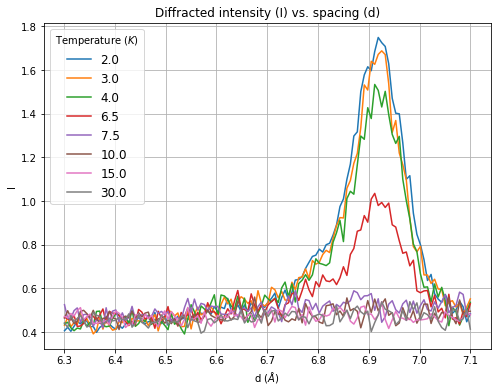

In [17]:
plot("Diffracted intensity (I) vs. spacing (d)","d ($Å$) ","I")
for i, temp in enumerate(files):
    plt.plot( files[temp][:,0],files[temp][:,1], label = float(temperatures[i]) )         #plot data

plt.legend(title = "Temperature ($K$)" ,loc = 'upper left', prop={'size': 12})

The diffractograms show well defined diffraction peaks when the experiment was done at low temperatures (2.0K-6.5K), with the peaks' magnitudes decreasing with temperature. There is a clear magnetic phase transition in the temperature range of 6.5K - 7.5K, above which the material does not exhibit antiferromagnetic properties.

### Gauss - Newton fits

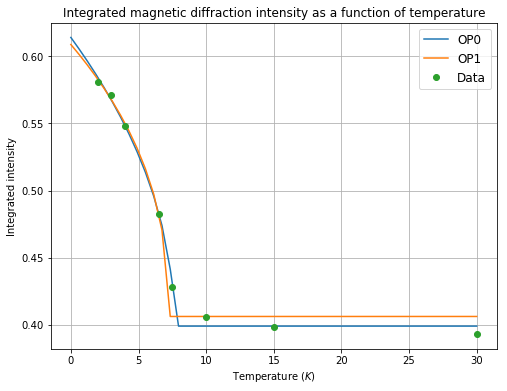

In [18]:
plot()
x = np.linspace(0,30)
for i, p in enumerate(initial_parameters[:-3]):    #errors poduced by chosing the last three initial parameters
    A, T0, β, B = newton_fit(p)
    plt.plot(x ,M(x, A, T0, β, B), label = "OP{}".format(i) )
plt.plot( data_x, data_y, "o", label = "Data")
plt.legend(prop={'size': 12})


The Newton-Gauss method is very sensitive to the starting points. The initial parameters have to be very close to the optimal parameters for N-G to converge and not produces errors.

The only altered parameters with which the G-N was able to converge was p01, where the transition temperature *t0* was decreased. The fit was shifted upwards and to the left.

### L-M fits (curve_fit)

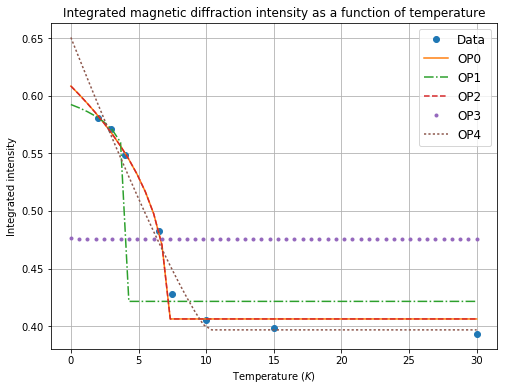

In [19]:
plot()
optimal_parameters={}
x = np.linspace(0,30)

plt.plot( data_x, data_y, "o", label = "Data")  #plot original data 

lines = "- -. -- . :".split(" ")  # used to change the format of the lines

for i, p in enumerate(initial_parameters):
        OP = curve_fit(M, data_x, data_y, p )[0]
        optimal_parameters[ "OP{}".format(str(i)) ]= OP
        A, T0, β, B = OP
        plt.plot(x ,M(x, A, T0, β, B),lines[i], label = "OP{}".format(i) )
plt.legend(prop={'size': 12})

warnings.filterwarnings("ignore")

OP0 and OP1 returned by both methods are similar and OP0 appears to be a good fit.
However, *Curve-fit* always converges when each of the [parameters](#Parameters) is changed.
An amplitude A =1.6 (OP2) seems to produce a good fit for the T<T0 section of the graph but raises the remaining section.

A small change in  $\beta$  does not cause much deviation from the optimal (OP0) curve,as it completely covers OP0. However, around  $ \beta =2.14 $ , a decrease of magnitute  *−3*  changes the curve drastically; to a straight line.

As *T* tends to 0K, the estimated magnetic diffraction intensity appears to approach 0.6.



### Speed of each method
The *timeit* in build jupyter function was used to determine the fastest curve fitting method

In [20]:
% timeit newton_fit(p00)
warnings.filterwarnings("ignore")

100 loops, best of 3: 17.7 ms per loop


In [21]:
% timeit curve_fit(M, data_x, data_y, p00 )
warnings.filterwarnings("ignore")

1000 loops, best of 3: 559 µs per loop


`curve_fit` converges at a much greater speed than `newton_fit`.

### Fitting Gaussian curve to peaks

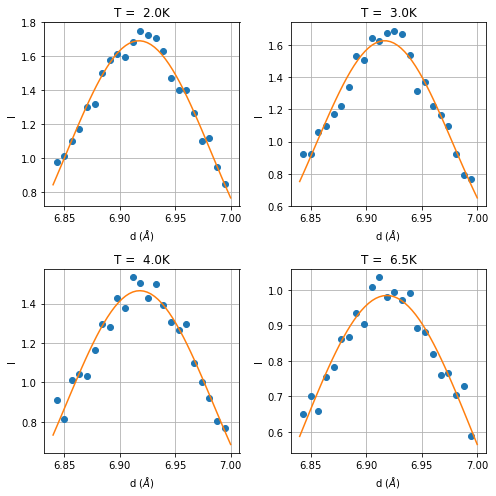

In [64]:
fig = plt.figure(figsize=(7,7))

import pandas 

#bounds 
lower  = 6.84
upper = 7.0

x = np.linspace(lower, upper)
I_integrals = {}

for i, t in enumerate(temperatures[:-4]):
    df = pandas.DataFrame(files['data_{}'.format(t)]) #creating dataframe so as to extract I and d values within range                      
    df = df[(df[0] > lower) & (df[0] <upper)]
    d = df[0]
    I = df[1]         
    
#     d = np.array([300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355])
#     I = np.array([ 5.14403019,  3.35193535, -4.52526266,  8.29367785, 28.30717486,
#            47.99174292, 50.23491997, 54.59357307, 48.20739473, 25.79665365,
#             9.65047367,  0.21379872])
    
    plt.subplot(2,2,i+1)
    plt.plot(d,I, "o", label = float(t) )       #plot original data

    n = len(d)                          #set parameters for Gaussian function
    mean = sum(d*I)/n                   
    sigma = sum(I*(d-mean)**2)/n 

    
    a, x0, sigma = curve_fit(gauss_function, df[0],df[1], p0=[1,mean,sigma])[0] # fit data to Gaussian
    I_fit = gauss_function(x,  a, x0, sigma )
    
    I_integrals[float(t)] = np.trapz( I_fit, x )# Integrate Gaussian curve
    
    plt.plot(x, I_fit)    
    
    plt.xlabel("d ($Å$) ")
    plt.ylabel("I")
    plt.title("T =  {}K".format(float(t)))
    plt.grid()
    
    
plt.tight_layout()

The range had to be greatly restricted for the fits to be reasonably good. For each temperature, the shape of the curves and accuracy is very similar.

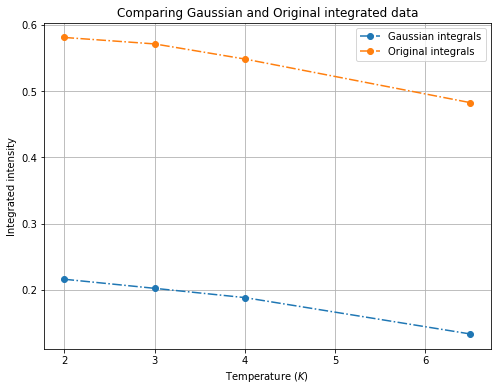

In [23]:
plot("Comparing Gaussian and Original integrated data")
plt.plot(list(I_integrals.keys()), list(I_integrals.values()), "o-.",label = "Gaussian integrals")
plt.plot( data_x[:-4], data_y[:-4], "o-.", label = "Original integrals")
plt.legend()

The integrals appear to have increased in magnitute but the ratios between each points remained the same.

### Interpolating

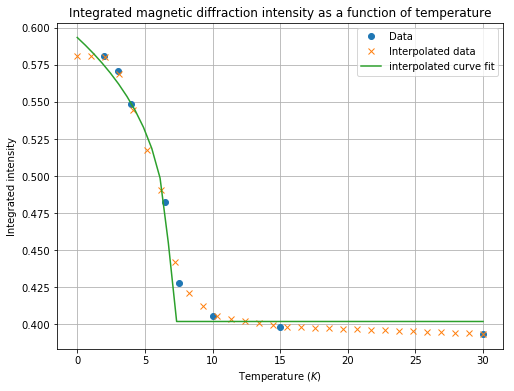

In [24]:
x = np.linspace(0,30)
plot()
plt.plot( data_x, data_y, "o", label = "Data")
A, T0, β, B = coefficients                                         # unpacking coefficients found using combination of points
plt.plot(x_interpolated, y_interpolated, "x",label="Interpolated data" ) #plotting interpolated points
plt.plot(x, M(x, A, T0, β, B), label ="interpolated curve fit") 
plt.legend()

The additional points did not change the fit greatly, however, they do emphasize that the transition at *T0* may not be gradual.

In [25]:
print("{:14}{:5}".format("Parameters","χ2"))
print("_"*(25))
for key in optimal_parameters:
    print("{:14}{:5.5e}".format(key,chi_squared(data_x, data_y, optimal_parameters[key])) ) 
print("{:12}  {:5.5e}".format("Interpolated", chi_squared(data_x, data_y, coefficients) ))


Parameters    χ2   
_________________________
OP0           1.79844e-04
OP1           1.33688e-03
OP2           1.79844e-04
OP3           1.13695e-02
OP4           2.26006e-04
Interpolated  2.27175e-04


The $\chi^{2}$ is the smallest, and hence, most accurate for OP0 and OP2. So a change in the amplitude A of 1.52 did not change the quality of the fit.

However, even a small change of 0.005 in β altered the $\chi^{2}$ value by a factor of 2 (OP4/OP3). 

The additional, interpolated points with the original parameters did not increase $\chi^{2}$ by a significant amount; $~4.6 \times 10^{-5}$. 

# 4. Discussion

The L-M method was found to be superior to the G-N method. When G-N succeeds in converging it produces a similar fit, but its rate of convergence is significantly greater.  This may be because G-N converges only to a local optimum that depends on the starting parameters.  But, in practice, if the function *M* is locally well-approximated by a quadratic form, then convergence to a local minimum is quadratic. However, the curvature of the error surface of the nonlinear *M* can vary significantly over the parameter space.  Although L-M is still greatly dependent on initial parameters, it is a refinement G-N that increases the chance of local convergence and prohibits divergence, hence, it was the main method chosen in further analysing the data.

Fitting the peaks to Gaussian curves was not beneficial in obtaining improved values for the integrated intensity. The range chosen was too small, and the temperatures for which peaks were apparent were too few. 

In [26]:
print("Optimal parameters and corresponding χ2 test \n")
print("{:10}    {:10} {:<10} {:10} {:10} {:10}".format('P', 'A',  'T0',  'β',  'B', "χ2")) #print header
print("_"*(67))
for p in optimal_parameters:
    A, T0, β, B = optimal_parameters[p]
    print( "{:10} {:10.5f} {:10.5f} {:10.5f} {:10.5f} {:12.3e}".format(p, A, T0, β, B,chi_squared(data_x, data_y, optimal_parameters[p])) )
A, T0, β, B = coefficients   
print( "{:10} {:10.5f} {:10.5f} {:10.5f} {:10.5f} {:12.3e}".format('Interp', A, T0, β, B,chi_squared(data_x, data_y, optimal_parameters[p])) )


Optimal parameters and corresponding χ2 test 

P             A          T0         β          B          χ2        
___________________________________________________________________
OP0           0.08872    7.19324    0.41704    0.40629    1.798e-04
OP1           0.14558    4.28426    0.10965    0.42153    1.337e-03
OP2           0.08872    7.19324    0.41704    0.40629    1.798e-04
OP3           0.01062    0.31953    2.57361    0.47601    1.137e-02
OP4           0.01670   10.12743    1.17517    0.39681    2.260e-04
Interp        0.10752    6.83050    0.30136    0.40170    2.260e-04


Any alterations to the starting points did not improve the results, as determined by the $\chi^2$ test. The alterations did show the effect on the fits; the model is particularly sensitive to *T0* and $\beta$ and least sensitive to *A*. A particularly troubling result was when $\beta$ was changed from 0.5 to 2.14. The fit was still good ($\chi^2 = 2.260\times10^{-4} $), so the true value of  $\beta$ can be within that range. This could because there are few data points in the region T<T0. 
Adding interpolated data did not improve the fit, this could also be because relatively few points were added to this region. The added points did suggest that the magnetic transition may be more gradual than modelled. 

# 5. Conclusions


The integration technique was very accurate and the chosen curve-fitting algorithm (L-M) was very robust and produced visibly good fits. Optimal parameters (OP0) were found accurately according to the $\chi^2$ test. According to the interpolated fit and OP4, which are also reasonably accurate, there may be a large uncertainty in most of the values, besides *B*. The greatest uncertainty may lie in $\beta$. Further statistical analysis, possibly using the covariance matrix returned by the 'curve_fit' could be used to find values for the uncertainties. 

Fitting the peaks was not fruitful, but if the range was increased, they could be fitted with two Gaussian curves, a smaller one on the left of the main peak.
More data in around the transition temperature and especially $T<T0$ should be collected so as to determine the critical exponent and *T0*, and the intensity as *T* tends to zero more accurately. If the additional data continue to show the same trend, a different model in which the at the transition temperature the curve is smooth and where at $T>T0$ the curve decreases in magnitude instead of remaining constant, such as $ \frac{1}{x} $ or a negative exponential. 

## References

[1] C. G. Shull and J. Samuel Smart, Phys. Rev. 76, 1256 (1949).

[2] ISIS Neutron diffraction [Internet]. Isis.stfc.ac.uk. 2018 [cited 10 November 2018]. Available from: https://www.isis.stfc.ac.uk/Pages/Neutron-diffraction.aspx#

[3] scipy.optimize.curve_fit — SciPy v1.1.0 Reference Guide [Internet]. Docs.scipy.org. 2018 [cited 10 November 2018]. Available from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

[4] M. K. Transtrum and J. P. Sethna, Preprint submitted to Journal of
Computational Physics, (2012).

[5] C. G. Shull, W. A. Strauber, Aid E. O. Wollan, Phys. Rev. 83, 2, (1951).

In [1]:
np.trapz(gauss_function(xi, a,  x0 ,  sigma),xi,dx=10**(-6))

NameError: name 'np' is not defined